In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from plotly.graph_objs import Figure, Histogram, Layout

In [173]:
pd.set_option('display.max_columns', 50)

In [196]:
countries = ['US', 'DE', 'CA', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU']
dframes = [code.lower()+'_df' for code in countries]

cat_ids = pd.read_csv('yt category list.csv', delimiter=' - ', engine='python')
for code, df in zip(countries, dframes):
    globals()[df] = pd.read_csv(f'{code}videos.csv', parse_dates=['trending_date', 'publish_time'], \
                                encoding_errors='ignore').merge(cat_ids, on='category_id', how='inner')\
                                .drop(['category_id', 'thumbnail_link'], axis=1)

In [215]:
# we now have a dataframe for each of the countries
# but we want to start by analyzing only one dataframe first
# lets start with the US

df = us_df
df.head(3)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,description,category,trending_delta
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,0 days 06:46:59
1,0mlNzVSJrT0,2017-11-14,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"cute|""cats""|""thai""|""eggs""",98966,2486,184,532,Kittens come out of the eggs in a Thai commerc...,People & Blogs,206 days 17:12:28
2,STI2fI7sKMo,2017-11-14,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,2017-11-11 15:00:03+00:00,"shawn johnson|""andrew east""|""shawn east""|""shaw...",321053,4451,1772,895,Subscribe for weekly videos ▶ http://bit.ly/sj...,People & Blogs,2 days 08:59:57


In [198]:
# lets first remove some bias
# this will be videos with comments or ratings disabled
# this will also be videos with errors or has been removed

df = df[~(df['comments_disabled'] | \
                df['ratings_disabled'] | \
                df['video_error_or_removed']) == True]

df = df.drop(['comments_disabled', 'ratings_disabled', 'video_error_or_removed'], axis=1)
df.head(3)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,description,category
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs
1,0mlNzVSJrT0,17.14.11,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"cute|""cats""|""thai""|""eggs""",98966,2486,184,532,Kittens come out of the eggs in a Thai commerc...,People & Blogs
2,STI2fI7sKMo,17.14.11,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,2017-11-11 15:00:03+00:00,"shawn johnson|""andrew east""|""shawn east""|""shaw...",321053,4451,1772,895,Subscribe for weekly videos ▶ http://bit.ly/sj...,People & Blogs


In [212]:
# trending date is of type object, which is not valuable to us.
# lets make that a datetime object, then aggregate to find how long a video will take to trend

df['trending_date'] = pd.to_datetime(us_df['trending_date'], format='%y.%d.%m')
df['trending_delta'] = df['trending_date'] - df['publish_time'].dt.tz_localize(None)
df.head(3)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,description,category,trending_delta
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,0 days 06:46:59
1,0mlNzVSJrT0,2017-11-14,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"cute|""cats""|""thai""|""eggs""",98966,2486,184,532,Kittens come out of the eggs in a Thai commerc...,People & Blogs,206 days 17:12:28
2,STI2fI7sKMo,2017-11-14,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,2017-11-11 15:00:03+00:00,"shawn johnson|""andrew east""|""shawn east""|""shaw...",321053,4451,1772,895,Subscribe for weekly videos ▶ http://bit.ly/sj...,People & Blogs,2 days 08:59:57


In [244]:
df['description'][0]

"SHANTELL'S CHANNEL - https://www.youtube.com/shantellmartin\\nCANDICE - https://www.lovebilly.com\\n\\nfilmed this video in 4k on this -- http://amzn.to/2sTDnRZ\\nwith this lens -- http://amzn.to/2rUJOmD\\nbig drone - http://tinyurl.com/h4ft3oy\\nOTHER GEAR ---  http://amzn.to/2o3GLX5\\nSony CAMERA http://amzn.to/2nOBmnv\\nOLD CAMERA; http://amzn.to/2o2cQBT\\nMAIN LENS; http://amzn.to/2od5gBJ\\nBIG SONY CAMERA; http://amzn.to/2nrdJRO\\nBIG Canon CAMERA; http://tinyurl.com/jn4q4vz\\nBENDY TRIPOD THING; http://tinyurl.com/gw3ylz2\\nYOU NEED THIS FOR THE BENDY TRIPOD; http://tinyurl.com/j8mzzua\\nWIDE LENS; http://tinyurl.com/jkfcm8t\\nMORE EXPENSIVE WIDE LENS; http://tinyurl.com/zrdgtou\\nSMALL CAMERA; http://tinyurl.com/hrrzhor\\nMICROPHONE; http://tinyurl.com/zefm4jy\\nOTHER MICROPHONE; http://tinyurl.com/jxgpj86\\nOLD DRONE (cheaper but still great);http://tinyurl.com/zcfmnmd\\n\\nfollow me; on http://instagram.com/caseyneistat\\non https://www.facebook.com/cneistat\\non https://twit

In [247]:
df['description'].str.findall(r'[.]*').str.len()

0        1411.0
1         103.0
2         631.0
3         733.0
4         666.0
          ...  
40944     391.0
40945     391.0
40946     391.0
40947     391.0
40948     391.0
Name: description, Length: 40230, dtype: float64

In [237]:
df['description'].str.findall(r'\w\W*').str.len()

0        1095.0
1          84.0
2         492.0
3         579.0
4         528.0
          ...  
40944     314.0
40945     314.0
40946     314.0
40947     314.0
40948     314.0
Name: description, Length: 40230, dtype: float64

In [259]:
# lets also aggregate certain columns for better analysis

df['like_pct'] = 100 * round(df['likes'] / df['views'], 2) # ratio of likes to views
df['len_title'] = df['title'].str.findall(r'[.]*').str.len() # count chars in title
df['len_desc'] = df['description'].str.findall(r'[.]*').str.len() # count chars in desc
df['pct_cap'] = 100 * round(df['title'].str.findall(r'[A-Z]').str.len() /
                df['title'].str.findall(r'[A-Za-z]').str.len(), 2) # ratio of cap letters in title
df['qty_tags'] = df['tags'].str.split('|').str.len() # count number of tags

df.head(3)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,description,category,trending_delta,like_pct,len_title,len_desc,pct_cap,qty_tags
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,0 days 06:46:59,8.0,35,1411.0,100.0,1
1,0mlNzVSJrT0,2017-11-14,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"cute|""cats""|""thai""|""eggs""",98966,2486,184,532,Kittens come out of the eggs in a Thai commerc...,People & Blogs,206 days 17:12:28,3.0,21,103.0,24.0,4
2,STI2fI7sKMo,2017-11-14,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,2017-11-11 15:00:03+00:00,"shawn johnson|""andrew east""|""shawn east""|""shaw...",321053,4451,1772,895,Subscribe for weekly videos ▶ http://bit.ly/sj...,People & Blogs,2 days 08:59:57,1.0,76,631.0,79.0,44


In [306]:
df.groupby('category').agg({'category':['count'], \
                            'views': ['mean', 'std']})

category         views              
                         count          mean           std
category                                                  
 Film & Animation         2301  3.141956e+06  5.616662e+06
Autos & Vehicles           369  1.398908e+06  3.434380e+06
Comedy                    3455  1.481164e+06  2.010166e+06
Education                 1644  7.179818e+05  8.804807e+05
Entertainment             9749  2.062894e+06  5.860244e+06
Gaming                     809  2.640352e+06  3.173307e+06
Howto & Style             4135  9.839684e+05  1.931552e+06
Music                     6447  6.213627e+06  1.548558e+07
News & Politics           2313  5.406228e+05  9.131640e+05
Nonprofits & Activism       53  3.187433e+06  7.351101e+06
People & Blogs            3130  1.409027e+06  2.351468e+06
Pets & Animals             916  8.339888e+05  1.103646e+06
Science & Technology      2310  1.390258e+06  3.449548e+06
Shows                       57  9.035273e+05  5.108668e+05
Sports                    2140  2.037210e+06  4.043653e+06
Travel & Events            402  8.546196e+05  1.918995e+06

In [297]:
# lets first see how much of each category there is

df.groupby('category').agg(count=('category', 'count'),
                           views=('views', 'mean'), 
                           likes=('likes', ['mean', 'std']))

TypeError: unhashable type: 'list'

<AxesSubplot:xlabel='category'>

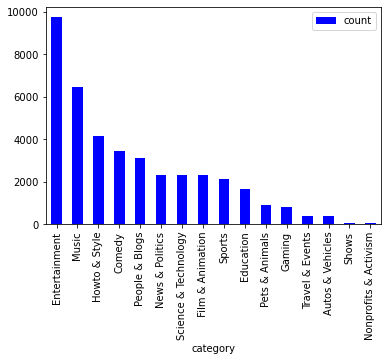

In [159]:
us_df.groupby('category').agg(count=('category', 'count'))\
.sort_values(by='count', ascending=False).plot.bar(color = 'b')

In [248]:
pct_cap = us_df['title'].str.findall(r'[A-Z]').str.len() / us_df['title'].str.findall(r'[a-zA-Z]').str.len()

pct_cap

0        1.000000
1        0.235294
2        0.785714
3        0.526316
4        0.210526
           ...   
40944    0.266667
40945    0.266667
40946    0.266667
40947    0.266667
40948    0.266667
Name: title, Length: 40230, dtype: float64

In [253]:
100 * (df['title'].str.findall(r'[A-Z]*').str.len() /
                df['title'].str.findall(r'[A-Za-z]*').str.len())

0        100.000000
1        262.500000
2        135.483871
3        196.153846
4        287.500000
            ...    
40944    180.000000
40945    180.000000
40946    180.000000
40947    180.000000
40948    180.000000
Name: title, Length: 40230, dtype: float64

(array([ 2980., 16720., 11682.,  2228.,  1264.,  1008.,   782.,   548.,
          310.,  2661.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

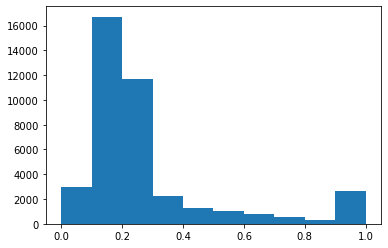

In [252]:
plt.hist(pct_cap)

In [8]:
from datetime import tzinfo, timedelta, datetime

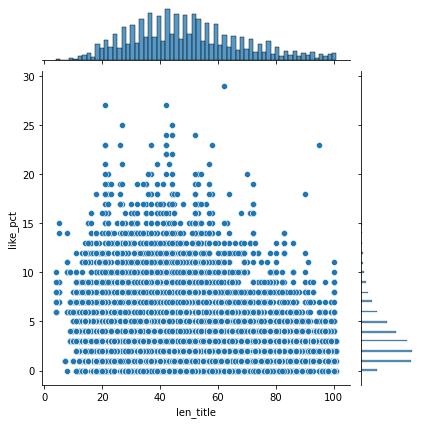

In [261]:
sns.jointplot(x='len_title', y='like_pct', data=us_df, palette='Set2')

<BarContainer object of 40949 artists>

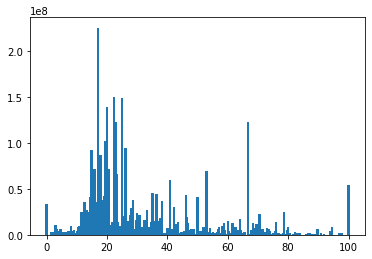

In [114]:
plt.bar(pct_cap * 100, us_df['views'])

<AxesSubplot:xlabel='len_desc', ylabel='like_pct'>

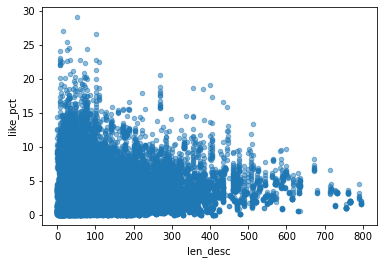

In [9]:
us_df.plot.scatter('len_desc', 'like_pct', alpha=0.5)

(array([18878., 11959.,  4708.,  2636.,  1200.,   472.,   246.,   174.,
           19.,    87.]),
 array([  0. ,  79.6, 159.2, 238.8, 318.4, 398. , 477.6, 557.2, 636.8,
        716.4, 796. ]),
 <BarContainer object of 10 artists>)

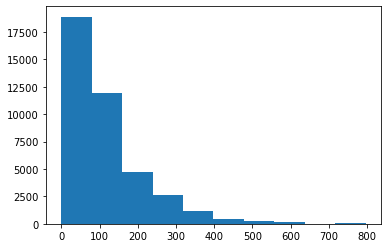

In [10]:
plt.hist(us_df['len_desc'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa91803efa0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa9198c6640>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa91803ecd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa9198c6b20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa9198c6df0>],
 'means': []}

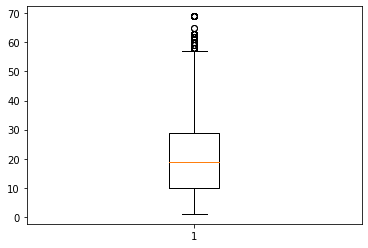

In [11]:
plt.boxplot(us_df['qty_tags'])

<AxesSubplot:>

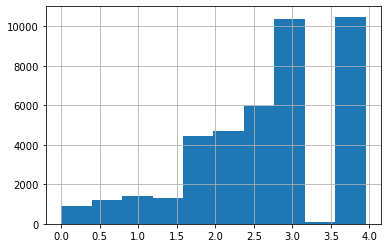

In [12]:
np.log(us_df['publish_date'].dt.isocalendar().week).hist()

<AxesSubplot:ylabel='Frequency'>

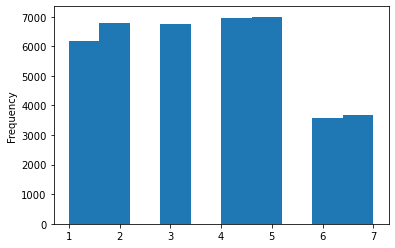

In [13]:
us_df['publish_date'].dt.isocalendar().day.plot.hist()

In [14]:
us_df[us_df['channel_title'] == 'Vox']

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,...,ratings_disabled,video_error_or_removed,description,category,like_pct,len_desc,len_title,qty_tags,publish_date,trending_delta
21377,TUmyygCMMGA,2017-11-14,Why the rise of the robots won’t mean the end ...,Vox,2017-11-13 13:45:16+00:00,"vox.com|""vox""|""explain""|""shift change""|""future...",256426,12654,1363,2368,...,False,False,"For now, at least, we have better things to wo...",News & Politics,4.934757,172.0,12,20,2017-11-13,1 days
21391,TUmyygCMMGA,2017-11-15,Why the rise of the robots won’t mean the end ...,Vox,2017-11-13 13:45:16+00:00,"vox.com|""vox""|""explain""|""shift change""|""future...",635985,20721,2417,4111,...,False,False,"For now, at least, we have better things to wo...",News & Politics,3.258096,172.0,12,20,2017-11-13,2 days
21403,_BVAJ3PXZ1k,2017-11-16,The all-American fruit you've probably never h...,Vox,2017-11-15 11:30:00+00:00,"vox.com|""vox""|""explain""|""pawpaw""|""paw paw""|""fr...",533940,12633,597,1828,...,False,False,"The founding fathers loved the pawpaw fruit, s...",News & Politics,2.365996,95.0,8,41,2017-11-15,1 days
21416,lJFqvRwOiis,2017-11-17,Walking while black,Vox,2017-11-16 12:55:39+00:00,"vox.com|""vox""|""explain""|""race""|""poverty""|""tick...",505886,23207,5375,7030,...,False,False,Jacksonville’s enforcement of pedestrian viola...,News & Politics,4.587397,186.0,3,35,2017-11-16,1 days
21431,5HOijUtExiM,2017-11-18,The environmental cost of free two-day shipping,Vox,2017-11-17 13:00:12+00:00,"vox.com|""vox""|""explain""|""ucla""|""environmentali...",366048,14742,1308,1948,...,False,False,What’s the environmental impact of online shop...,News & Politics,4.027341,259.0,7,33,2017-11-17,1 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23853,Nd3zqXro_P0,2018-06-10,Why 350°F is the magic number for baking,Vox,2018-06-07 12:00:02+00:00,"baking|""maillard reaction""|""s pen""|""Vox.com""|""...",621100,13749,535,1395,...,False,False,Turns out there’s a lot of chemistry in cookin...,News & Politics,2.213653,128.0,8,22,2018-06-07,3 days
23856,Nd3zqXro_P0,2018-06-11,Why 350°F is the magic number for baking,Vox,2018-06-07 12:00:02+00:00,"baking|""maillard reaction""|""s pen""|""Vox.com""|""...",673657,14433,569,1445,...,False,False,Turns out there’s a lot of chemistry in cookin...,News & Politics,2.142485,128.0,8,22,2018-06-07,4 days
23859,Nd3zqXro_P0,2018-06-12,Why 350°F is the magic number for baking,Vox,2018-06-07 12:00:02+00:00,"baking|""maillard reaction""|""s pen""|""Vox.com""|""...",741829,15368,618,1506,...,False,False,Turns out there’s a lot of chemistry in cookin...,News & Politics,2.071636,128.0,8,22,2018-06-07,5 days
23861,Nd3zqXro_P0,2018-06-13,Why 350°F is the magic number for baking,Vox,2018-06-07 12:00:02+00:00,"baking|""maillard reaction""|""s pen""|""Vox.com""|""...",782283,15845,643,1542,...,False,False,Turns out there’s a lot of chemistry in cookin...,News & Politics,2.025482,128.0,8,22,2018-06-07,6 days


In [15]:
us_df['channel_title'].value_counts().head(50)

ESPN                                      203
The Tonight Show Starring Jimmy Fallon    197
Vox                                       193
Netflix                                   193
TheEllenShow                              193
The Late Show with Stephen Colbert        187
Jimmy Kimmel Live                         186
Late Night with Seth Meyers               183
Screen Junkies                            182
NBA                                       181
CNN                                       180
Saturday Night Live                       175
WIRED                                     171
BuzzFeedVideo                             169
INSIDER                                   167
The Late Late Show with James Corden      163
TED-Ed                                    162
Tom Scott                                 159
WWE                                       157
CollegeHumor                              156
First We Feast                            153
HellthyJunkFood                   

<AxesSubplot:xlabel='trending_delta', ylabel='qty_tags'>

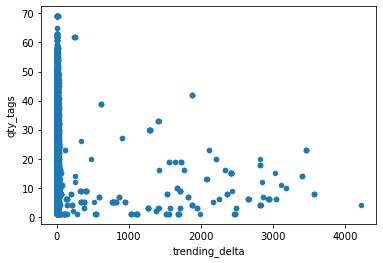

In [95]:
tmp = pd.DataFrame(us_df['trending_delta'].dt.days).join(us_df['qty_tags'])
tmp.plot.scatter('trending_delta', 'qty_tags')

Text(0.5, 1.0, '')

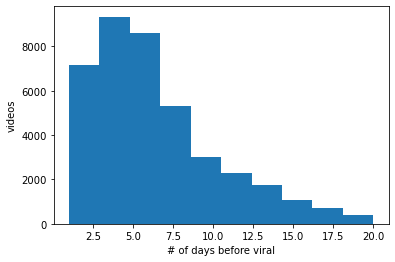

In [17]:
plt.hist(us_df['trending_delta'].dt.days, range=(1, 20))
plt.xlabel('# of days before viral')
plt.ylabel('videos')
plt.title('')

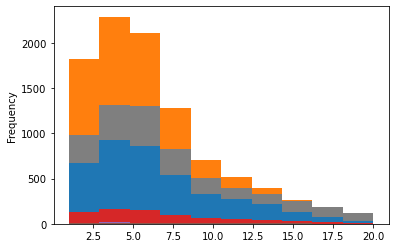

In [18]:
for c in list(us_df['category'].unique()):
    us_df[us_df['category'] == c]['trending_delta'].dt.days.plot.hist(range=(1, 20))

Text(0, 0.5, 'count')

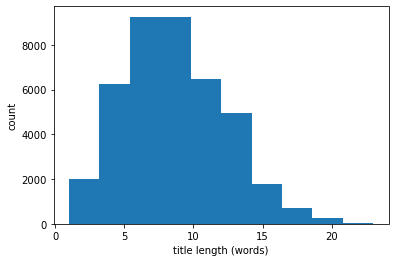

In [19]:
plt.hist(us_df['len_title'], bins=10, )
plt.xlabel('title length (words)')
plt.ylabel('count')